In [1]:
import sys

import os
import os.path as osp

import glob

import numpy as np

# for comparing predictions to lab analysis data frames
import pandas as pd

# for plotting
import matplotlib
# enable LaTeX style fonts
matplotlib.rc('text', usetex=True)
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# evaluation metrics
from sklearn.metrics import r2_score

from plot_utils import *

In [2]:
root_path = '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/'

jpeg_files = glob.glob(root_path + '*.jpg')
jpeg_files.sort()

# Should equal 40
print(len(jpeg_files)) 

40


In [3]:
DATA_PATH = r'/scratch/gallowaa/cciw/Data'

imagetable_path = os.path.join(DATA_PATH, 'Tables', 'ImageTable.csv')
image_df = pd.read_csv(imagetable_path, index_col=0)
analysis_path = os.path.join(DATA_PATH, 'Tables', 'Analysis.csv')
dive_path = os.path.join(DATA_PATH, 'Tables', 'Dives.csv')
analysis_df = pd.read_csv(analysis_path, index_col=0, dtype={'Count':float})
dive_df = pd.read_csv(dive_path, index_col=0, parse_dates=['Date'])
data_df = pd.merge(analysis_df, dive_df, on='Dive Index', how='outer')

In [4]:
fontsize = 16

left = 0.02  # the left side of the subplots of the figure
right = 0.98   # the right side of the subplots of the figure
bottom = 0.05  # the bottom of the subplots of the figure
top = 0.95     # the top of the subplots of the figure
wspace = 0.15  # the amount of width reserved for space between subplots,
# expressed as a fraction of the average axis width
hspace = 0.1  # the amount of height reserved for space between subplots,
# expressed as a fraction of the average axis height

In [5]:
lab_targets = np.zeros((len(jpeg_files), 3)) # 0 = biomass, 1 = count

names = ['16mm', '14mm', '12.5mm', '10mm', '8mm', '6.3mm', '4mm', '2mm']
sieves = np.array([16, 14, 12.5, 10, 8, 6.3, 4, 2])

BIOMASS_IDX = 0
COUNT_IDX = 1
PRED_COUNT_IDX = 2

for i in range(len(jpeg_files)):
    
    root_fname = jpeg_files[i].split('/')[-1].split('.')[0].split('_image')[0].split('Lab_')[1]
    guid = image_df[image_df['Name'].str.contains(root_fname)]['Analysis Index'].astype('int64')
    row = data_df[data_df['Analysis Index'].values == np.unique(guid.values)]
    
    lab_targets[i, BIOMASS_IDX] = row['Biomass'].values
    lab_targets[i, COUNT_IDX] = row['Count'].values
    
    size_dist = np.zeros(len(names))
    for j in range(len(names)):
        size_dist[j] = row[names[j]].values
        
    lab_targets[i, PRED_COUNT_IDX] = (lab_targets[i, BIOMASS_IDX] * size_dist * 2 / sieves).sum()

lab_targets[np.isnan(lab_targets)] = 0

biomass = lab_targets[:, BIOMASS_IDX] / lab_targets[:, BIOMASS_IDX].max()
a_count = lab_targets[:, COUNT_IDX] / lab_targets[:, COUNT_IDX].max()
p_count = lab_targets[:, PRED_COUNT_IDX] / lab_targets[:, PRED_COUNT_IDX].max()

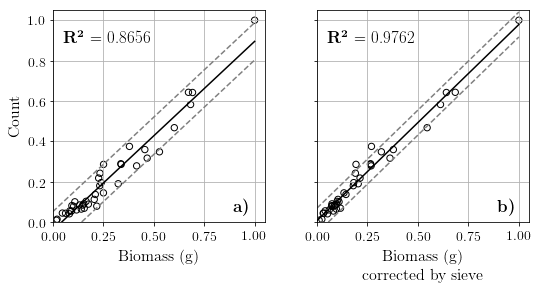

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax[0].scatter(biomass, a_count, marker='o', s=40, facecolors='none', edgecolors='k')
ax[0].set_ylabel('Count', fontsize=fontsize)
ax[0].set_xlabel('Biomass (g)', fontsize=fontsize)

ax[1].scatter(p_count, a_count, marker='o', s=40, facecolors='none', edgecolors='k')
ax[1].set_xlabel('Biomass (g) \n corrected by sieve', fontsize=fontsize)

draw_lines(ax[0], biomass, a_count)
draw_lines(ax[1], p_count, a_count)

draw_rsquared(ax[0], a_count, biomass, fontsize)
draw_rsquared(ax[1], a_count, p_count, fontsize)

draw_sublabel(ax[0], r'\textbf{a)}', fontsize)
draw_sublabel(ax[1], r'\textbf{b)}', fontsize)

pretty_axis(ax[0], fontsize)
pretty_axis(ax[1], fontsize)

plt.tight_layout()

In [ ]:
fname = 'lab_count_from_biomass'
fig.savefig(fname + '.png')
fig.savefig(fname + '.eps', format='eps')